# Classification avec Transformer (Encoder seul)

In [13]:
# !pip install dill

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score, roc_auc_score

import sys
sys.path.append('..')
from utils import *

## Chargement et prétraitement des données (seulement en anglais)

In [2]:
# toots = pd.read_csv('../data/offensive_toots.csv').dropna()[['content', 'y']]
# print('Taille des toots au début', len(toots))

# # toots pos et neg
# itoots_pos = toots['y'] == 1
# itoots_neg = toots['y'] == 0
# toots_pos = toots[itoots_pos]
# toots_neg = toots[itoots_neg]

# indices = np.array([i for i in range(len(toots_neg))])
# np.random.shuffle(indices)
# toots_neg = toots_neg.iloc[indices[:len(toots_pos)]]

# # Concaténation par lignes (axis=0)
# toots = pd.concat([toots_neg, toots_pos], axis=0, ignore_index=True)

# print(f'Nb pos: {len(toots_pos)} -- Nb neg: {len(toots_neg)} -- total: {len(toots)}')

# toots.head()

Taille des toots au début 47465
Nb pos: 1011 -- Nb neg: 1011 -- total: 2022


,content,y
0,Hazel with her herding ball. There is about 5 ...,0
1,#Earthquake (#deprem) M1.8 strikes 30 km NE of...,0
2,Here's the source code for the script that gen...,0
3,Do you consider it rude or stalky to scroll to...,0
4,"ScienceDailyScienceDaily: ""Your source for th...",0


## Prétraitement et sauvegarde des embeddings (8 minutes)

In [3]:
# from transformers import AutoTokenizer, AutoModel
# import torch

# # Charger le modèle de tokenizer et le modèle de langue
# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = AutoModel.from_pretrained("bert-base-uncased")

# # Obtenir les embeddings pour chaque mot de chaque phrase
# ldata = []
# MAX_LENGTH = 250
# for it in range(len(toots_pos)):
#     print(f'{it} / {len(toots_pos)}', end='\r')
#     toot = toots.iloc[it]
#     phrase = toot['content']
#     y = toot['y']
    
#     # Obtenir les embeddings des tokens
#     embeddings = model(torch.tensor([tokenizer.encode(phrase)[:MAX_LENGTH]]))[0]
    
#     ldata.append((embeddings, y))

# save_object('../data/offensive_toots_emb_pos.dill', ldata)


Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors


In [4]:

# # Obtenir les embeddings pour chaque mot de chaque phrase
# ldata = []
# MAX_LENGTH = 250
# for it in range(len(toots_neg)):
#     print(f'{it} / {len(toots_neg)}', end='\r')
#     toot = toots.iloc[it]
#     phrase = toot['content']
#     y = toot['y']
    
#     # Obtenir les embeddings des tokens
#     embeddings = model(torch.tensor([tokenizer.encode(phrase)[:MAX_LENGTH]]))[0]
    
#     ldata.append((embeddings, y))

# save_object('../data/offensive_toots_emb_neg.dill', ldata)


## Charger les embeddings déjà prétraités et enregistrés

deux fichiers embed pos et neg pour ça tienne en mémoire: 
- '../data/offensive_toots_emb_pos.dill'
- '../data/offensive_toots_emb_neg.dill'

In [2]:
MAX_LENGTH = 60

ldata_pos = load_object('../data/offensive_toots_emb_pos.dill')
ldata_neg = load_object('../data/offensive_toots_emb_neg.dill')
ldata = ldata_pos + ldata_neg
ldata = [(embs.squeeze(dim=0)[:MAX_LENGTH], torch.tensor([0,1], dtype=torch.float32) ) for embs,y in ldata_pos] + \
  [(embs.squeeze(dim=0)[:MAX_LENGTH], torch.tensor([1,0], dtype=torch.float32) ) for embs,y in ldata_neg]

# shuffle
indices = np.array([i for i in range(len(ldata))])
np.random.shuffle(indices,)

ldata2 = [ldata[i] for i in indices]
ldata = ldata2

## DataLoader

In [3]:
class MyData(Dataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

dataset = MyData(ldata)

test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
def collate_batch(batch):
  lembs, labels = zip(*batch)
  
  padded_embs = pad_sequence(lembs, batch_first=True, padding_value=0)

  # Ajoutez du padding à droite avec des vecteurs remplis de zéros pour atteindre la longueur maximale
  padded_embs = torch.nn.functional.pad(padded_embs, (0, 0, 0, MAX_LENGTH - padded_embs.size(1)))

  # Le résultat sera un tensor de taille (batch_size, max_sequence_length, 768)
  return padded_embs, torch.stack(labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch, shuffle=True)

## Transformer

In [4]:
class SAttention(nn.Module):
  def __init__(self, k, heads, mask=False):
    """

    :param k: taille de l'embeding
    :param heads: nombre de heads
    :param mask: attention sur toute la seq(False) ou les elts precs seulement
    """
    
    super(SAttention, self).__init__()
    
    assert k % heads == 0, f'heads ({heads}) doit etre un diviseur de k ({k})'

    self.k = k
    self.heads = heads
    self.mask = mask
    
    self.tokeys = nn.Linear(k, k, bias=False)
    self.toqueries = nn.Linear(k, k, bias=False)
    self.tovalues = nn.Linear(k, k, bias=False)

    self.unifyHeads = nn.Linear(k,k)
  
  def forward(self, x):
    
    b, t, k = x.size()
    h = self.heads
    assert k == self.k, f'Taille des embeddings ({k}) doit correspond a celui du init ({self.k})'

    keys = self.tokeys(x)
    queries = self.toqueries(x)
    values = self.tovalues(x)
    
    # Taille de chaque head
    s = k // h
    
    # batch x longueur seq x nb heads x taille head
    keys = keys.view(b, t, h, s)
    queries = queries.view(b, t, h, s)
    values = values.view(b, t, h, s)
    
    # batch et head cote à cote
    keys = keys.transpose(1, 2).contiguous().view(b * h, t, s)
    queries = queries.transpose(1, 2).contiguous().view(b * h, t, s)
    values = values.transpose(1, 2).contiguous().view(b * h, t, s)

    dot = torch.bmm(queries, keys.transpose(1, 2)) # -> (b*h, t, t)
    dot = dot / (k ** (1/2))
    
    if self.mask:
      indices = torch.triu_indices(t, t, offset=1)
      dot[:, indices[0], indices[1]] = float('-inf')

    dot = F.softmax(dot, dim=2)
    
    out = torch.bmm(dot, values).view(b, h, t, s)

    # rearrangement
    out = out.transpose(1, 2).contiguous().view(b, t, h*s)

    # unification avec MLP
    out = self.unifyHeads(out) # -> (b, t, k)

    return out

class TBlock(nn.Module):
  def __init__(self, k, heads):
    super(TBlock, self).__init__()
    
    self.attention = SAttention(k, heads)
    self.norm1 = nn.LayerNorm(k)
    self.norm2 = nn.LayerNorm(k)

    self.feedforward = nn.Sequential(
      nn.Linear(k, 4*k),
      nn.ReLU(),
      nn.Linear(4*k, k)
    )
  
  def forward(self, x):
    attention = self.attention(x)
    x = x + attention
    x = self.norm1(x)
    
    feedforward = self.feedforward(x)
    x = x + feedforward
    out = self.norm2(x)

    return out

class Transformer(nn.Module):
  def __init__(self, seq_len=MAX_LENGTH, nb_labels=2, dim=768, D=256, heads=4, L=6, name=None):
    super(Transformer, self).__init__()
    
    # self.T = input_len  # lookback input size
    # self.S = pred_len   # lookforward size, prediction size
    # self.N = N          # nb series multivariees
    
    self.seq_len = seq_len
    self.nb_labels = nb_labels
    self.dim = dim      # dim de chaque elt de chaque seq
    self.D = D          # dim embeddings
    self.heads = heads  # nb attention heads
    self.L = L          # nb TBlocks
    self.name = name
    
    self.toEmbs = nn.Linear(self.dim, self.D)
    
    # self.toEmbs = nn.Sequential(
    #   nn.Linear(self.dim, 4 * self.dim),
    #   nn.Dropout(p=0.1),
    #   nn.ReLU(),
    #   nn.Linear(4 * self.dim, self.D)
    # ) # seq_len x dim -> seq_len x D
    # print(f'embs params \n{self.toEmbs.parameters}')

    tblocks = [TBlock(k=self.D, heads=heads) for _ in range(L)] # heads diviseur de D
    self.tblocks = nn.Sequential(*tblocks) # seq_len x D -> seq_len x D
    
    # projection
    self.projection = nn.Linear(self.seq_len*self.D, self.nb_labels)
    # self.projection = nn.Sequential(
    #   nn.Linear(self.seq_len*self.D, self.D),
    #   nn.Dropout(p=0.1),
    #   nn.ReLU(),
    #   nn.Linear(self.D, 4 * self.D),
    #   nn.Dropout(p=0.1),
    #   nn.ReLU(),
    #   nn.Linear(4 * self.D, 8 * self.D),
    #   nn.Dropout(p=0.1),
    #   nn.ReLU(),
    #   nn.Linear(8 * self.D, 16 * self.D),
    #   nn.Dropout(p=0.1),
    #   nn.ReLU(),
    #   nn.Linear(16 * self.D, self.nb_labels)
    # ) # seq_len x D -> seq_len x S (transpose) -> S x N
    
    # print('Constructeur de iTransformer')
    # print(f'lb {self.T} lf {self.S} mvs {N}')
  
  def forward(self, x):
    """

    Args:
      x (b, lookbacksize, N): entree batch de sequences multi variees
    """
    # print('Forward Transformer')
    b, seq_len, dim = x.size()
    # print(f'size batch {x.size()}')

    assert seq_len == self.seq_len, f'Taille de la sequence ({seq_len}) doit correspondre a self.seq_len({self.seq_len})'
    assert dim == self.dim, f'Dimension en entrée ({dim}) doit correspondre à self.dim({self.dim})'
    

    H0 = self.toEmbs(x)   # (b, seq_len, dim) -> (b, seq_len, D)
    # print(f'H0 embed size {H0.size()}')

    HL = self.tblocks(H0) # (b, seq_len, D) -> (b, seq_len, D)
    # print(f'HL embed size {HL.size()}')

    # prediction
    out = self.projection(HL.view(b,-1))   # (b, seq_len * D) -> (b, nb_labels)
    out = F.softmax(out, dim=1)
    # print(f'projection size {out.size()} -- b {b} x nb labels {self.nb_labels}')
    
    return out



In [5]:
def f1score(y_true, y_pred):
  epsilon=1e-7
  # Calculez les vrais positifs, faux positifs et faux négatifs
  tp = torch.sum(y_true * y_pred)
  fp = torch.sum((1 - y_true) * y_pred)
  fn = torch.sum(y_true * (1 - y_pred))

  # Calculez la précision, le rappel et le F1 score
  precision = tp / (tp + fp + epsilon)
  recall = tp / (tp + fn + epsilon)
  f1 = 2 * (precision * recall) / (precision + recall + epsilon)

  return f1

def balanced_accuracy(lyhat, ly):
  lyhat, ly = torch.tensor(lyhat), torch.tensor(ly)

  ipos, ineg = ly == 1, ly == 0
  ly_pos, ly_neg = ly[ipos], ly[ineg]
  lyhat_pos, lyhat_neg = lyhat[ipos], lyhat[ineg]

  tp = (lyhat_pos == ly_pos).sum()
  tn = (lyhat_neg == ly_neg).sum()
  
  sensitive_p = tp / len(ly_pos)
  sensitive_n = tn / len(ly_neg)

  ba = (sensitive_p + sensitive_n) / 2
  
  return ba

def raucAuc(self, lyhat, ly):
  # Convertir les listes en tenseurs PyTorch
  predictions_prob = torch.tensor(predictions_prob)
  targets = torch.tensor(targets)

  # Utiliser scikit-learn pour calculer l'aire sous la courbe ROC (ROC-AUC)
  roc_auc = roc_auc_score(np.array(lyhat), np.array(ly))

  return roc_auc


In [6]:
def apprentissage(net, criterion, optimizer, train_dl, test_dl, epochs):
  train_loss, test_loss = [], []
  for epoch in range(epochs):
    print(f"Epoch [{(epoch+1):4d}/{epochs:4d}] ")
    lep = []
    net.train()
    for batch_idx, (batch, y) in enumerate(train_dl):

      yhat = net(batch)
      loss = criterion(y, yhat)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # save loss train
      lep.append(loss.detach().numpy())
      
      print(
        f"\ttrain batch [{(batch_idx+1):4d}/{len(train_dl):4d}] - "
        f"Loss : {lep[-1]:.4f} ", end="\r"
      )
    print(
      f"\ttrain batch [{(batch_idx+1):4d}/{len(train_dl):4d}] - "
      f"Loss : {lep[-1]:.4f} "
    )
    train_loss.append(np.mean(lep))
    
    lep = []
    net.eval()
    for batch_idx, (batch, y) in enumerate(test_dl):

      yhat = net(batch)
      loss = criterion(y, yhat)
      lep.append(loss.detach().numpy())
      
      print(
        f"\ttest batch [{(batch_idx+1):4d}/{len(test_dl):4d}] - "
        f"Loss : {lep[-1]:.4f} ", end="\r"
      )
    print(
      f"\ttest batch [{(batch_idx+1):4d}/{len(test_dl):4d}] - "
      f"Loss : {lep[-1]:.4f} "
    )
    test_loss.append(np.mean(lep))
  
  return train_loss, test_loss

def prediction(net, dl):
  net.eval()
  lyhat, ly = [], []
  for batch_idx, (batch, y) in enumerate(dl):
    
    yhat = net(batch)
    
    labels = torch.argmax(y, dim=1) # [0,1] pos et [1,0] neg
    preds  = torch.argmax(yhat, dim=1) # arg1 pos
    
    ly.extend(labels)
    lyhat.extend(preds)

  lyhat, ly = torch.vstack(lyhat).squeeze(), torch.vstack(ly).squeeze()
  print('y', torch.bincount(ly))
  print('yhat', torch.bincount(lyhat))

  ipos, ineg = ly == 1, ly == 0
  ly_pos, ly_neg = ly[ipos], ly[ineg]
  lyhat_pos, lyhat_neg = lyhat[ipos], lyhat[ineg]

  print(f'Taux de prediction total: {(100*((lyhat == ly).sum()/ len(ly))):.2f}%')
  print(f'Taux de prediction sur les pos: {(100*((lyhat_pos == ly_pos).sum()/ len(ly_pos))):.2f}%')
  print(f'Taux de prediction sur les neg: {(100*((lyhat_neg == ly_neg).sum()/ len(ly_neg))):.2f}%')
  
  f1_sc_pos = f1score(ly, lyhat)
  f1_sc_neg = f1score(1-ly, 1-lyhat)
  print(f'F1 score (positifs): {(100*f1_sc_pos):.2f}%')
  print(f'F1 score (négatifs): {(100*f1_sc_neg):.2f}%')
  
  f1_macro_loss = (f1_sc_pos + f1_sc_neg) / 2
  print(f'f1 macro score : {(100*f1_macro_loss):.2f}%')

  # scores
  tp = (lyhat_pos == ly_pos).sum()
  tn = (lyhat_neg == ly_neg).sum()
  fp = (lyhat_pos != ly_pos).sum()
  fn = (lyhat_neg != ly_neg).sum()

  accuracy_score = (tp + tn) / (tp + tn + fp + fn)
  precision_score = tp / (tp + fp)
  recall_score = tp / (tp + fn)
  f1_score = 2*precision_score*recall_score / (precision_score + recall_score)

  print(f'\naccuracy score: {(100*accuracy_score):.2f}%')
  print(f'precision score: {(100*precision_score):.2f}%')
  print(f'recall score: {(100*recall_score):.2f}%')
  print(f'f1 score: {(100*f1_score):.2f}%')
  
  return lyhat


## Apprentissage

In [7]:
net = Transformer()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

epochs = 3

In [29]:
for batch_idx, (batch, y) in enumerate(train_loader):
  yhat = net(batch)
  
  break

In [11]:
train_loss, test_loss = apprentissage(net, criterion, optimizer, train_loader, test_loader, epochs)

Epoch [   1/   3] 
	train batch [  26/  26] - Loss : 0.9244 
	test batch [   7/   7] - Loss : 0.6633 
Epoch [   2/   3] 
	train batch [  26/  26] - Loss : 1.1466 
	test batch [   7/   7] - Loss : 0.7633 
Epoch [   3/   3] 
	train batch [  26/  26] - Loss : 0.7577 
	test batch [   7/   7] - Loss : 1.0133 


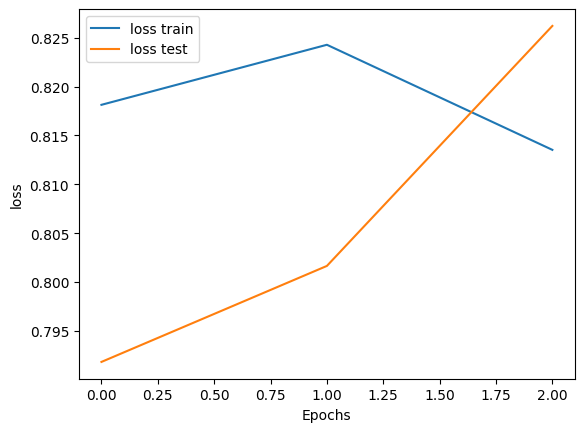

In [12]:
plt.plot(train_loss, label='loss train')
plt.plot(test_loss, label='loss test')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Taux de bonnes prédiction dans train

### Taux de bonnes prédiction dans test

In [13]:
lyhat = prediction(net, test_loader)

y tensor([199, 205])
yhat tensor([  0, 404])
Taux de prediction total: 50.74%
Taux de prediction sur les pos: 100.00%
Taux de prediction sur les neg: 0.00%
F1 score (positifs): 67.32%
F1 score (négatifs): 0.00%
f1 macro score : 33.66%

accuracy score: 50.74%
precision score: 100.00%
recall score: 50.74%
f1 score: 67.32%
